In [1]:
import os
import cv2
import numpy as np
import kagglehub
import keras
import pandas as pd
import tensorflow.data as tfd
import tensorflow.image as tfi

import plotly.express as px
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50V2, MobileNetV2, DenseNet121
from IPython.display import clear_output as cls
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

c:\Users\Mercury\anaconda3\envs\project_sem5\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Processing

In [2]:
path = kagglehub.dataset_download("alessandrasala79/ai-vs-human-generated-dataset")

print("Path to dataset files:", path)
path = '/kaggle/input/ai-vs-human-generated-dataset/'

Using Colab cache for faster access to the 'ai-vs-human-generated-dataset' dataset.
Path to dataset files: /kaggle/input/ai-vs-human-generated-dataset


In [3]:
train_csv = pd.read_csv(path + "train.csv")
train_csv["file_name"] = path + train_csv["file_name"]

test_csv = pd.read_csv(path + "test.csv")
test_csv["file_path"] = path + test_csv["id"]

print(f"Number of training samples: {train_csv.shape[0]}")
print(f"Number of testing samples : {test_csv.shape[0]}")

Number of training samples: 79950
Number of testing samples : 5540


In [4]:
train_csv = train_csv.drop(columns='Unnamed: 0', axis=1)
train_csv.head()

,file_name,label
0,/kaggle/input/ai-vs-human-generated-dataset/tr...,1
1,/kaggle/input/ai-vs-human-generated-dataset/tr...,0
2,/kaggle/input/ai-vs-human-generated-dataset/tr...,1
3,/kaggle/input/ai-vs-human-generated-dataset/tr...,0
4,/kaggle/input/ai-vs-human-generated-dataset/tr...,1


In [5]:
train_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79950 entries, 0 to 79949
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  79950 non-null  object
 1   label      79950 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.2+ MB


In [6]:
test_csv.head()

,id,file_path
0,test_data_v2/1a2d9fd3e21b4266aea1f66b30aed157.jpg,/kaggle/input/ai-vs-human-generated-dataset/te...
1,test_data_v2/ab5df8f441fe4fbf9dc9c6baae699dc7.jpg,/kaggle/input/ai-vs-human-generated-dataset/te...
2,test_data_v2/eb364dd2dfe34feda0e52466b7ce7956.jpg,/kaggle/input/ai-vs-human-generated-dataset/te...
3,test_data_v2/f76c2580e9644d85a741a42c6f6b39c0.jpg,/kaggle/input/ai-vs-human-generated-dataset/te...
4,test_data_v2/a16495c578b7494683805484ca27cf9f.jpg,/kaggle/input/ai-vs-human-generated-dataset/te...


In [7]:
# ----------------- Check for Missing Files -----------------
# missing_files_train = train_csv[~train_csv["file_name"].apply(os.path.exists)]
# missing_files_test = test_csv[~test_csv["file_path"].apply(os.path.exists)]
# print(f"Missing train images: {len(missing_files_train)}")
# print(f"Missing test images: {len(missing_files_test)}")

In [8]:
# ----------------- Compute Class Distribution -----------------
class_distribution = train_csv['label'].value_counts()
class_distribution

,count
label,
1,39975
0,39975


In [9]:
# ----------------- Display Image Shapes -----------------
for i in range(5):
    image_path = os.path.join(path, train_csv.file_name[i])

    try:
        image = plt.imread(image_path)
        shape = image.shape

        print(f"Image {i+1}: {train_csv.file_name[i]}")
        print(f" - Shape: {shape}")
        print(f" - Image Path: {image_path}\n")

    except FileNotFoundError:
        print(f"⚠ Warning: File not found - {image_path}")

    except Exception as e:
        print(f"⚠ Error loading image {train_csv.file_name[i]}: {e}")

Image 1: /kaggle/input/ai-vs-human-generated-dataset/train_data/a6dcb93f596a43249135678dfcfc17ea.jpg
 - Shape: (768, 512, 3)
 - Image Path: /kaggle/input/ai-vs-human-generated-dataset/train_data/a6dcb93f596a43249135678dfcfc17ea.jpg

Image 2: /kaggle/input/ai-vs-human-generated-dataset/train_data/041be3153810433ab146bc97d5af505c.jpg
 - Shape: (768, 512, 3)
 - Image Path: /kaggle/input/ai-vs-human-generated-dataset/train_data/041be3153810433ab146bc97d5af505c.jpg

Image 3: /kaggle/input/ai-vs-human-generated-dataset/train_data/615df26ce9494e5db2f70e57ce7a3a4f.jpg
 - Shape: (512, 768, 3)
 - Image Path: /kaggle/input/ai-vs-human-generated-dataset/train_data/615df26ce9494e5db2f70e57ce7a3a4f.jpg

Image 4: /kaggle/input/ai-vs-human-generated-dataset/train_data/8542fe161d9147be8e835e50c0de39cd.jpg
 - Shape: (512, 768, 3)
 - Image Path: /kaggle/input/ai-vs-human-generated-dataset/train_data/8542fe161d9147be8e835e50c0de39cd.jpg

Image 5: /kaggle/input/ai-vs-human-generated-dataset/train_data/5d81

In [10]:
# ----------------- Convert Label Column to String -----------------
train_csv["label"] = train_csv["label"].astype(str)

# ----------------- Display First Few Rows -----------------
train_csv.head()

,file_name,label
0,/kaggle/input/ai-vs-human-generated-dataset/tr...,1
1,/kaggle/input/ai-vs-human-generated-dataset/tr...,0
2,/kaggle/input/ai-vs-human-generated-dataset/tr...,1
3,/kaggle/input/ai-vs-human-generated-dataset/tr...,0
4,/kaggle/input/ai-vs-human-generated-dataset/tr...,1


In [11]:
# ----------------- Initialize Data Generator -----------------
data_generator = ImageDataGenerator(rescale=1/255, validation_split=0.3)

In [12]:
# ----------------- Create Training Data Generator -----------------
train_generator = data_generator.flow_from_dataframe(
    train_csv,
    x_col="file_name",
    y_col="label",
    target_size=(512, 512),
    batch_size=32,
    class_mode="binary",
    subset="training"
)

# ----------------- Create Validation Data Generator -----------------
valid_generator = data_generator.flow_from_dataframe(
    train_csv,
    x_col="file_name",
    y_col="label",
    target_size=(512, 512),
    batch_size=32,
    class_mode="binary",
    subset="validation"
)

Found 55965 validated image filenames belonging to 2 classes.
Found 23985 validated image filenames belonging to 2 classes.


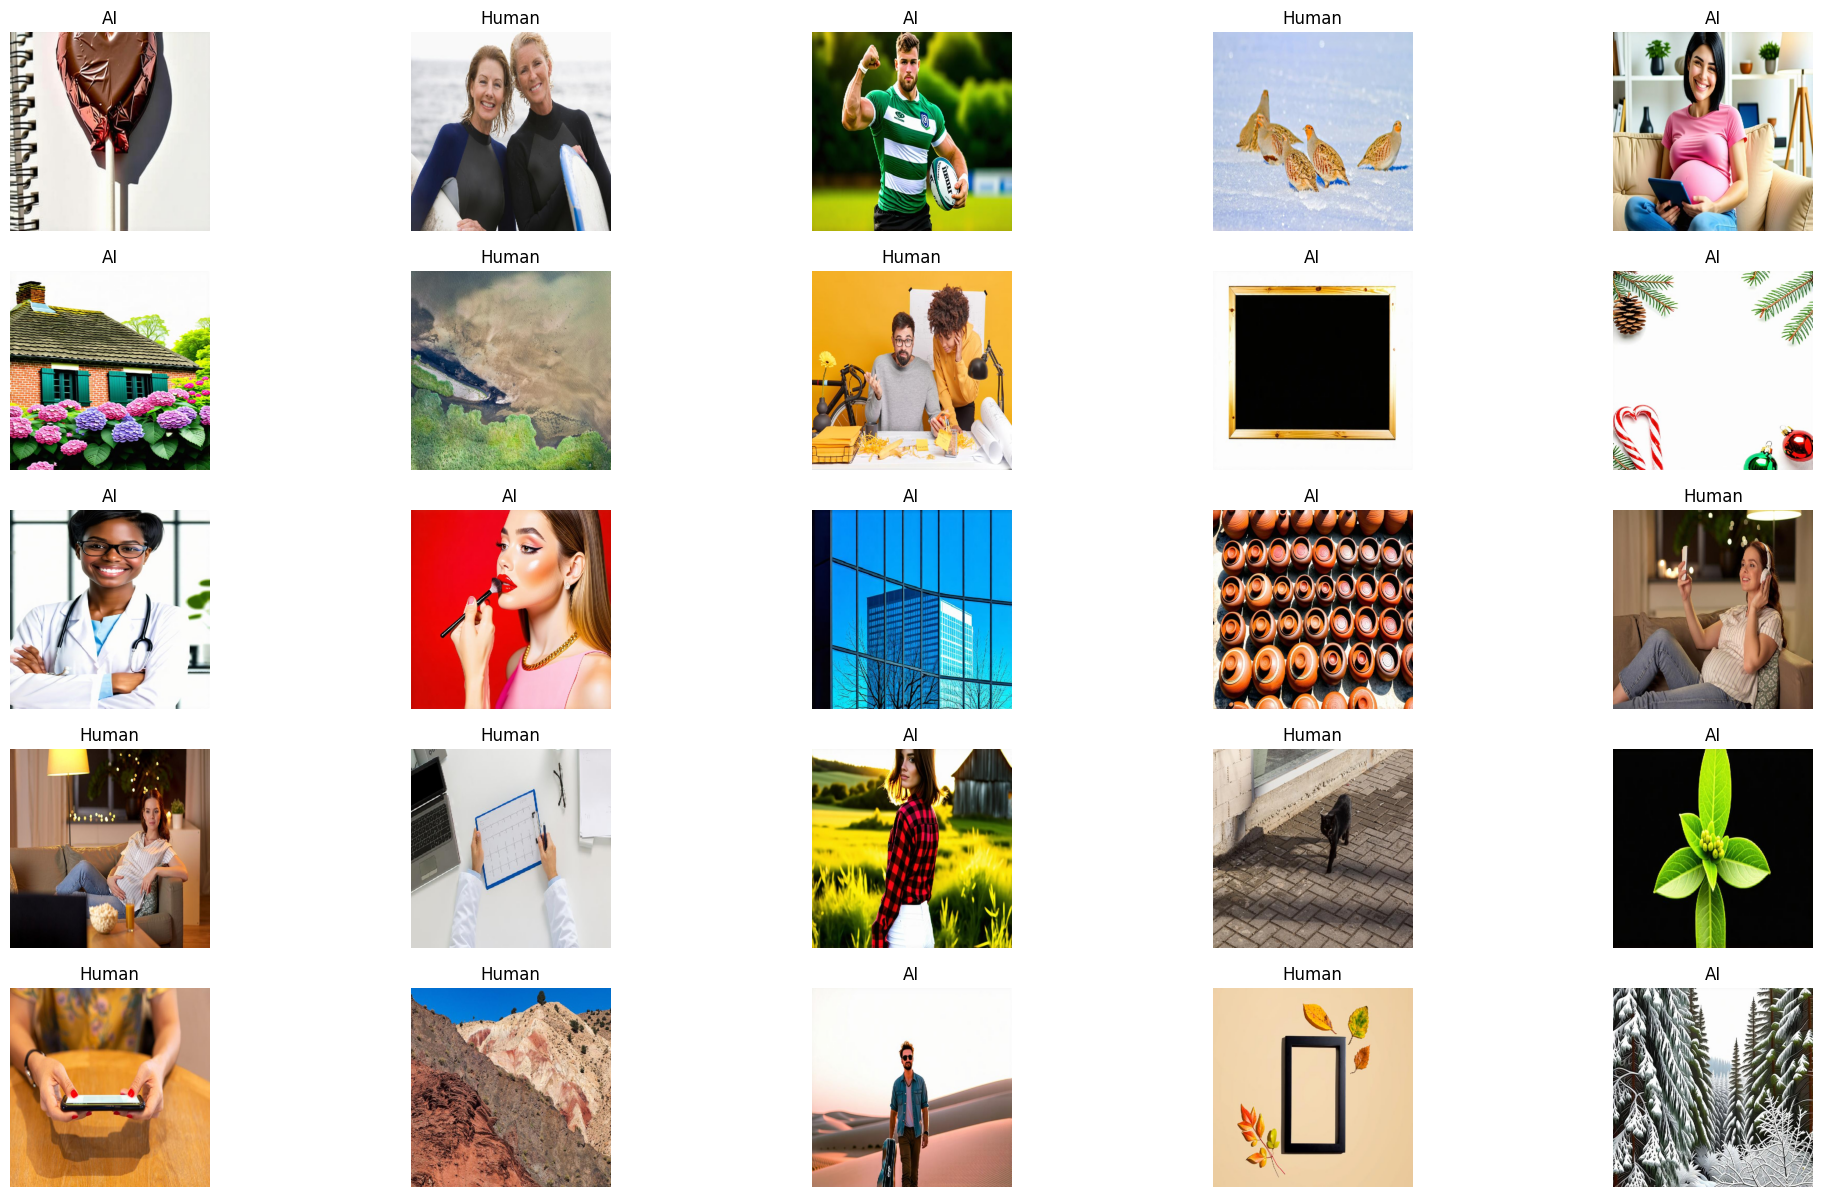

In [13]:
def show_images(data, n_rows=5, n_cols=5, figsize=(25, 15)):
    """
    Displays a grid of images from a given dataset.

    Args:
        data (tf.data.Dataset): The dataset containing images and labels.
        n_rows (int): Number of rows in the grid.
        n_cols (int): Number of columns in the grid.
        figsize (tuple): Figure size for the plot.

    Returns:
        None
    """
    images, labels = next(iter(data))

    plt.figure(figsize=figsize)

    n_image = 0

    for i in range(n_rows):
        for j in range(n_cols):
            if n_image < len(images):
                plt.subplot(n_rows, n_cols, n_image + 1)
                plt.imshow(images[n_image])
                plt.axis('off')
                plt.title("AI" if labels[n_image] == 1.0 else "Human")
                n_image += 1

    plt.show()

show_images(valid_generator)

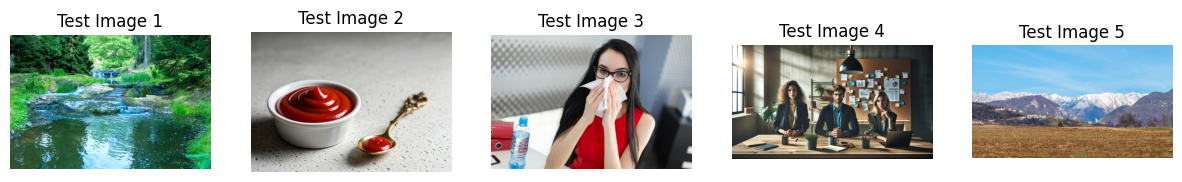

In [14]:
# ----------------- Function to Display Test Images -----------------
def show_test_images(df, num_images=5):
    sample_images = df.sample(num_images, random_state=42)["file_path"].values

    plt.figure(figsize=(15, 5))
    for i, img_path in enumerate(sample_images):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Test Image {i+1}")

    plt.show()

# ----------------- Show Test Images -----------------
show_test_images(test_csv)

# ResNet50V2 Model

In [22]:
resnet50v2_path = '/kaggle/input/ai-vs-human/tensorflow2/default/1/ResNet50V2-AIvsHumanGenImages.keras'

if os.path.exists(resnet50v2_path):
    resnet50_model = keras.models.load_model(resnet50v2_path, compile=True)
    resnet50_model.trainable = False
else:
    resnet50_base_model = ResNet50V2(
        input_shape=(512, 512, 3),
        include_top=False,
        weights='imagenet'
    )
    resnet50_base_model.trainable = False

    inputs = keras.Input(shape=(512, 512, 3))
    x = resnet50_base_model(inputs, training=False)
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(32, activation='relu')(x)
    x = keras.layers.Dropout(0.4)(x)
    outputs = keras.layers.Dense(1, activation='sigmoid')(x)

    resnet50_model = keras.Model(
        inputs=inputs,
        outputs=outputs,
        name='ResNet50V2-AIvsHumanGenImages'
    )

    resnet50_model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=[
            'accuracy',
            keras.metrics.Precision(name='precision'),
            keras.metrics.Recall(name='recall'),
        ]
    )

# ----------------- Model summary -----------------
resnet50_model.summary()

Model: "ResNet50V2-AIvsHumanGenImages"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 512, 512, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 16, 16, 2048)   │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │        65,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,630,401 (90.14 MB)

 Trainable params: 65,601 (256.25 KB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [23]:
resnet50v2_history_path = '/kaggle/input/ai-vs-human/tensorflow2/default/1/ResNet50V2-AIvsHumanGenImages-Logs.csv'

if os.path.exists(resnet50v2_history_path):
    resnet50v2_history = pd.read_csv(resnet50v2_history_path)  # Load training logs
else:
    steps_per_epoch = len(train_generator)
    validation_steps = len(valid_generator)
    resnet50_model_history = resnet50_model.fit(
        train_generator,
        epochs=10,
        steps_per_epoch=steps_per_epoch,
        validation_data=valid_generator,
        validation_steps=validation_steps,
        callbacks=[
            keras.callbacks.EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True),
            keras.callbacks.ModelCheckpoint('ResNet50V2-AIvsHumanGenImages.keras', save_best_only=True),
            keras.callbacks.CSVLogger('ResNet50V2-AIvsHumanGenImages-Logs.csv', append=True),
            keras.callbacks.TerminateOnNaN()
        ]
    )
    resnet50v2_history = pd.DataFrame(resnet50_model_history.history)
    resnet50v2_history.to_csv('ResNet50V2-AIvsHumanGenImages-Logs.csv', index=False)

resnet50v2_history.head()

Epoch 1/10
1749/1749 ━━━━━━━━━━━━━━━━━━━━ 1153s 654ms/step - accuracy: 0.8959 - loss: 0.2449 - precision: 0.8923 - recall: 0.9046 - val_accuracy: 0.9555 - val_loss: 0.1213 - val_precision: 0.9525 - val_recall: 0.9588
Epoch 2/10
1749/1749 ━━━━━━━━━━━━━━━━━━━━ 872s 498ms/step - accuracy: 0.9503 - loss: 0.1240 - precision: 0.9496 - recall: 0.9500 - val_accuracy: 0.9594 - val_loss: 0.1045 - val_precision: 0.9559 - val_recall: 0.9633
Epoch 3/10
1749/1749 ━━━━━━━━━━━━━━━━━━━━ 870s 497ms/step - accuracy: 0.9578 - loss: 0.1089 - precision: 0.9579 - recall: 0.9573 - val_accuracy: 0.9615 - val_loss: 0.1017 - val_precision: 0.9562 - val_recall: 0.9673
Epoch 4/10
1749/1749 ━━━━━━━━━━━━━━━━━━━━ 870s 498ms/step - accuracy: 0.9611 - loss: 0.0978 - precision: 0.9610 - recall: 0.9611 - val_accuracy: 0.9634 - val_loss: 0.0990 - val_precision: 0.9574 - val_recall: 0.9700
Epoch 5/10
1749/1749 ━━━━━━━━━━━━━━━━━━━━ 869s 497ms/step - accuracy: 0.9654 - loss: 0.0868 - precision: 0.9658 - recall: 0.9652 - val_

,accuracy,loss,precision,recall,val_accuracy,val_loss,val_precision,val_recall
0,0.925364,0.185520,0.923622,0.927418,0.955514,0.121348,0.952535,0.958809
1,0.950916,0.123267,0.950673,0.951183,0.959433,0.104540,0.955899,0.963312
2,0.957616,0.108115,0.958238,0.956937,0.961518,0.101693,0.956231,0.967314
3,0.960582,0.099386,0.961109,0.960010,0.963394,0.098955,0.957370,0.969983
4,0.964317,0.090391,0.965064,0.963512,0.964603,0.096427,0.966980,0.962061


In [24]:
train_loss, train_accuracy, *_ = resnet50_model.evaluate(train_generator)  # Ignore extra metrics
print(f"Accuracy on train data: {train_accuracy:.2%} | Loss: {train_loss:.4f}")

1749/1749 ━━━━━━━━━━━━━━━━━━━━ 620s 354ms/step - accuracy: 0.9808 - loss: 0.0541 - precision: 0.9819 - recall: 0.9795
Accuracy on train data: 98.11% | Loss: 0.0529


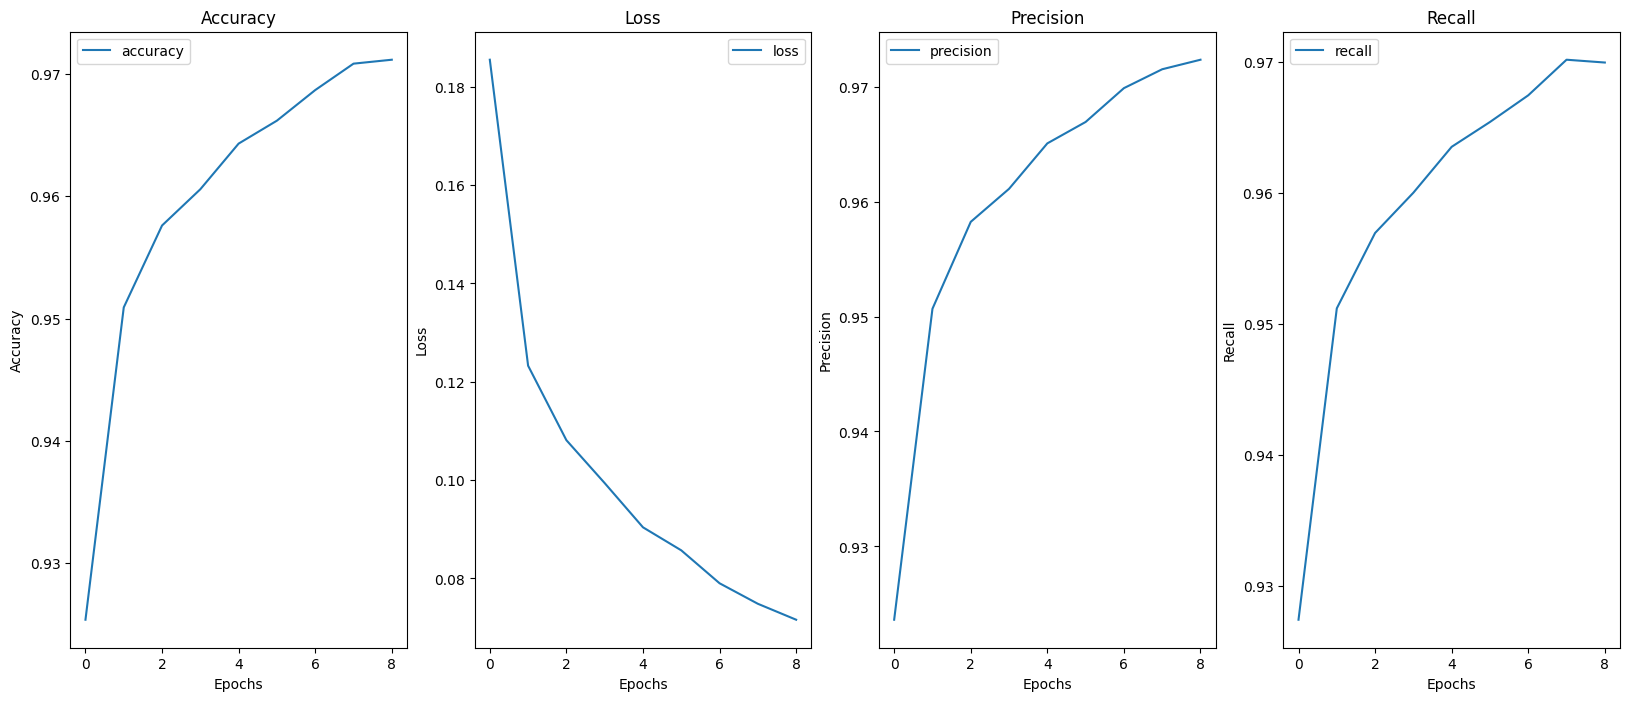

In [25]:
acc = resnet50_model_history.history['accuracy']
loss = resnet50_model_history.history['loss']
prec = resnet50_model_history.history['precision']
rec = resnet50_model_history.history['recall']

plt.figure(figsize=(20, 8))

plt.subplot(1, 4, 1)
plt.plot(acc, label='accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 4, 2)
plt.plot(loss, label='loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 4, 3)
plt.plot(prec, label='precision')
plt.title('Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

plt.subplot(1, 4, 4)
plt.plot(rec, label='recall')
plt.title('Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()

In [26]:
print("Manually saving the final model state...")
resnet50_model.save('ResNet50V2-AIvsHumanGenImages-Final.keras')
print("Model saved.")

Manually saving the final model state...
Model saved.


# MobileNetV2 Model

In [ ]:
mobilenetv2_path = '/kaggle/input/ai-vs-human/tensorflow2/default/1/MobileNetV2-AIvsHumanGenImages.keras'

if os.path.exists(mobilenetv2_path):
    mobilenet_model  = keras.models.load_model(mobilenetv2_path, compile=True)
    mobilenet_model.trainable = False
else:
    mobilenet_base_model = MobileNetV2(
        input_shape=(512, 512, 3),
        include_top=False,
        weights='imagenet'
    )

    mobilenet_base_model.trainable = False

    inputs = keras.Input(shape=(512, 512, 3))
    x = mobilenet_base_model(inputs, training=False)
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(32, activation='relu')(x)
    x = keras.layers.Dropout(0.4)(x)
    outputs = keras.layers.Dense(1, activation='sigmoid')(x)


    mobilenet_model = keras.Model(
        inputs=inputs,
        outputs=outputs,
        name='MobileNetV2-AIvsHumanGenImages'
    )

    mobilenet_model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=[
            'accuracy',
            keras.metrics.Precision(name='precision'),
            keras.metrics.Recall(name='recall'),
        ]
    )

mobilenet_model.summary()

/tmp/ipython-input-1262366717.py:7: UserWarning:

`input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.



9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "MobileNetV2-AIvsHumanGenImages"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 512, 512, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 16, 16, 1280)   │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        40,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,299,009 (8.77 MB)

 Trainable params: 41,025 (160.25 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
mobilenetv2_history_path  = '/kaggle/input/ai-vs-human/tensorflow2/default/1/MobileNetV2-AIvsHumanGenImages-Logs.csv'

if os.path.exists(mobilenetv2_history_path):
    mobilenet_model_history = pd.read_csv(mobilenetv2_history_path)
else:
    steps_per_epoch = len(train_generator)
    validation_steps = len(valid_generator)
    mobilenet_model_history = mobilenet_model.fit(
        train_generator,
        epochs=10,
        steps_per_epoch=steps_per_epoch,
        validation_data=valid_generator,
        validation_steps=validation_steps,
        callbacks=[
            keras.callbacks.EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True),
            keras.callbacks.ModelCheckpoint('MobileNetV2-AIvsHumanGenImages.keras', save_best_only=True),
            keras.callbacks.CSVLogger('MobileNetV2-AIvsHumanGenImages-Logs.csv', append=True),
            keras.callbacks.TerminateOnNaN()
        ]
    )
    mobilenetv2_history  = pd.DataFrame(mobilenet_model_history.history)
    mobilenetv2_history.to_csv('MobileNetV2-AIvsHumanGenImages-Logs.csv', index=False)

mobilenetv2_history.head()

Epoch 1/10
1749/1749 ━━━━━━━━━━━━━━━━━━━━ 1159s 663ms/step - accuracy: 0.9305 - loss: 0.1824 - precision: 0.9320 - recall: 0.9286 - val_accuracy: 0.9521 - val_loss: 0.1230 - val_precision: 0.9315 - val_recall: 0.9760
Epoch 2/10
1749/1749 ━━━━━━━━━━━━━━━━━━━━ 732s 417ms/step - accuracy: 0.9503 - loss: 0.1277 - precision: 0.9514 - recall: 0.9487 - val_accuracy: 0.9591 - val_loss: 0.1047 - val_precision: 0.9529 - val_recall: 0.9659
Epoch 3/10
1749/1749 ━━━━━━━━━━━━━━━━━━━━ 724s 414ms/step - accuracy: 0.9565 - loss: 0.1127 - precision: 0.9584 - recall: 0.9555 - val_accuracy: 0.9613 - val_loss: 0.1012 - val_precision: 0.9653 - val_recall: 0.9569
Epoch 4/10
1749/1749 ━━━━━━━━━━━━━━━━━━━━ 728s 417ms/step - accuracy: 0.9608 - loss: 0.1024 - precision: 0.9622 - recall: 0.9591 - val_accuracy: 0.9631 - val_loss: 0.1005 - val_precision: 0.9561 - val_recall: 0.9709
Epoch 5/10
1749/1749 ━━━━━━━━━━━━━━━━━━━━ 741s 416ms/step - accuracy: 0.9625 - loss: 0.0992 - precision: 0.9646 - recall: 0.9601 - val_

,accuracy,loss,precision,recall,val_accuracy,val_loss,val_precision,val_recall
0,0.938676,0.158668,0.939020,0.938282,0.952095,0.122974,0.931482,0.975986
1,0.951345,0.123245,0.953630,0.948824,0.959058,0.104724,0.952867,0.965897
2,0.956902,0.111153,0.958080,0.955614,0.961267,0.101206,0.965343,0.956892
3,0.960404,0.102460,0.961922,0.958759,0.963144,0.100502,0.956072,0.970900
4,0.962834,0.097610,0.963595,0.962011,0.961809,0.100487,0.972851,0.950138


In [ ]:
train_loss, train_accuracy, *_ = mobilenet_model.evaluate(train_generator)  # Ignore extra metrics
print(f"Accuracy on train data: {train_accuracy:.2%} | Loss: {train_loss:.4f}")

1749/1749 ━━━━━━━━━━━━━━━━━━━━ 515s 294ms/step - accuracy: 0.9800 - loss: 0.0541 - precision: 0.9769 - recall: 0.9834
Accuracy on train data: 97.94% | Loss: 0.0557


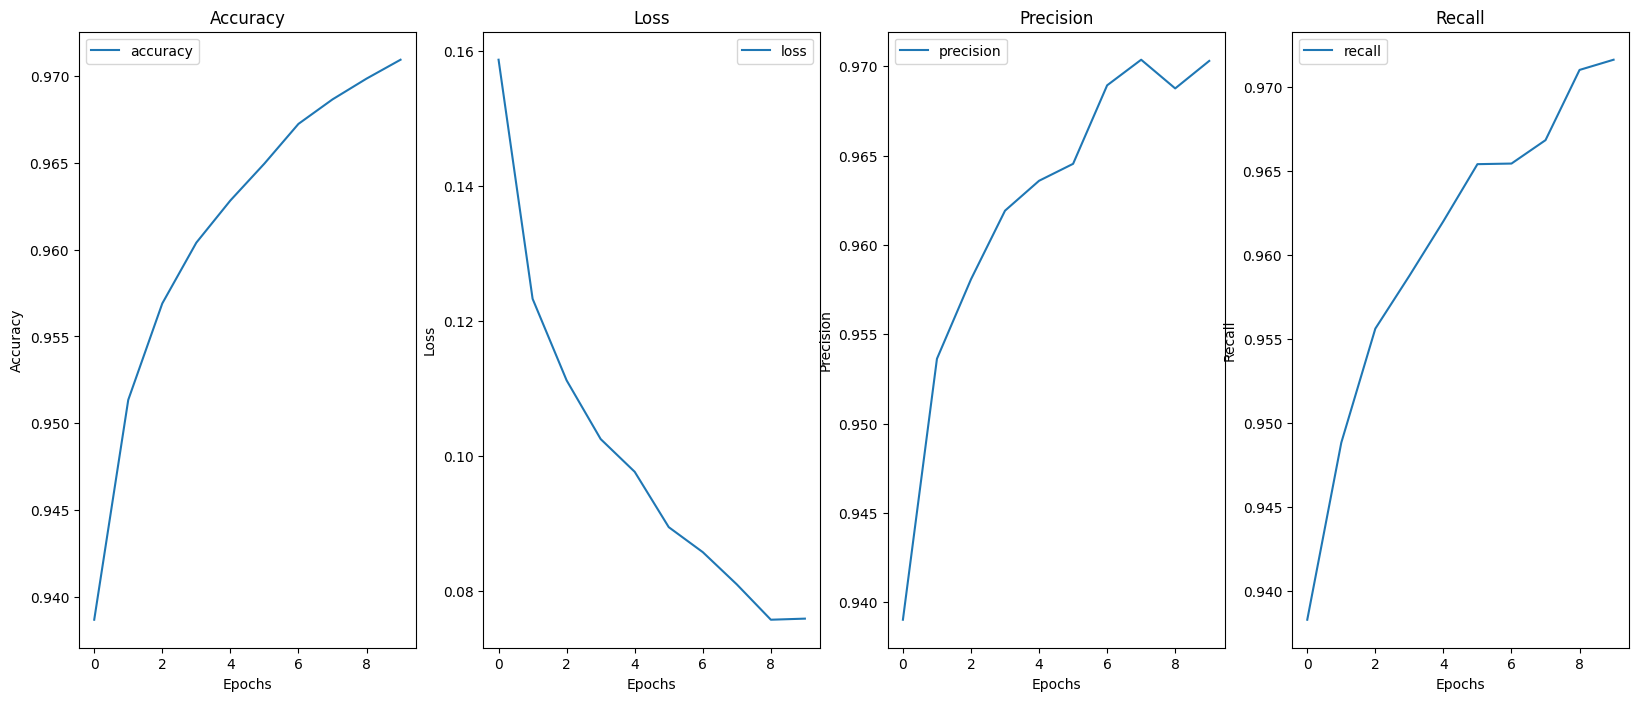

In [ ]:
acc = mobilenet_model_history.history['accuracy']
loss = mobilenet_model_history.history['loss']
prec = mobilenet_model_history.history['precision']
rec = mobilenet_model_history.history['recall']

plt.figure(figsize=(20, 8))

plt.subplot(1, 4, 1)
plt.plot(acc, label='accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 4, 2)
plt.plot(loss, label='loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 4, 3)
plt.plot(prec, label='precision')
plt.title('Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

plt.subplot(1, 4, 4)
plt.plot(rec, label='recall')
plt.title('Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()

In [ ]:
print("Manually saving the final model state...")
mobilenet_model.save('MobileNetV2-AIvsHumanGenImages-Final.keras')
print("Model saved.")

Manually saving the final model state...
Model saved.


# DenseNet121 Model

In [ ]:
densenet121_path = 'DenseNet121-AIvsHumanGenImages.keras'

if os.path.exists(densenet121_path):
    densenet_model = keras.models.load_model(densenet121_path, compile=True)
    densenet_model.trainable = False
else:
    densenet_base_model = DenseNet121(
        input_shape=(512, 512, 3),
        include_top=False,
        weights='imagenet'
    )
    densenet_base_model.trainable = False

    inputs = keras.Input(shape=(512, 512, 3))
    x = densenet_base_model(inputs, training=False)
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(32, activation='relu')(x)
    x = keras.layers.Dropout(0.4)(x)
    outputs = keras.layers.Dense(1, activation='sigmoid')(x)

    densenet_model = keras.Model(
        inputs=inputs,
        outputs=outputs,
        name='DenseNet121-AIvsHumanGenImages'
    )

    densenet_model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=[
            'accuracy',
            keras.metrics.Precision(name='precision'),
            keras.metrics.Recall(name='recall'),
        ]
    )

densenet_model.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "DenseNet121-AIvsHumanGenImages"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 512, 512, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 16, 16, 1024)   │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        32,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,070,337 (26.97 MB)

 Trainable params: 32,833 (128.25 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [ ]:
densenet121_history_path = 'DenseNet121-AIvsHumanGenImages-Logs.csv'

if os.path.exists(densenet121_history_path):
    densenet121_history = pd.read_csv(densenet121_history_path)
else:
    steps_per_epoch = len(train_generator)
    validation_steps = len(valid_generator)
    densenet_model_history = densenet_model.fit(
        train_generator,
        epochs=10,
        steps_per_epoch=steps_per_epoch,
        validation_data=valid_generator,
        validation_steps=validation_steps,
        callbacks=[
            keras.callbacks.EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True),
            keras.callbacks.ModelCheckpoint('DenseNet121-AIvsHumanGenImages.keras', save_best_only=True),
            keras.callbacks.CSVLogger('DenseNet121-AIvsHumanGenImages-Logs.csv', append=True),
            keras.callbacks.TerminateOnNaN()
        ]
    )
    densenet121_history = pd.DataFrame(densenet_model_history.history)
    densenet121_history.to_csv('DenseNet121-AIvsHumanGenImages-Logs.csv', index=False)

densenet121_history.head()

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



Epoch 1/10
1749/1749 ━━━━━━━━━━━━━━━━━━━━ 1160s 639ms/step - accuracy: 0.8777 - loss: 0.2838 - precision: 0.8732 - recall: 0.8863 - val_accuracy: 0.9470 - val_loss: 0.1358 - val_precision: 0.9646 - val_recall: 0.9280
Epoch 2/10
1749/1749 ━━━━━━━━━━━━━━━━━━━━ 885s 506ms/step - accuracy: 0.9453 - loss: 0.1410 - precision: 0.9463 - recall: 0.9444 - val_accuracy: 0.9519 - val_loss: 0.1222 - val_precision: 0.9685 - val_recall: 0.9342
Epoch 3/10
1749/1749 ━━━━━━━━━━━━━━━━━━━━ 922s 506ms/step - accuracy: 0.9504 - loss: 0.1254 - precision: 0.9510 - recall: 0.9492 - val_accuracy: 0.9557 - val_loss: 0.1143 - val_precision: 0.9643 - val_recall: 0.9465
Epoch 4/10
1749/1749 ━━━━━━━━━━━━━━━━━━━━ 921s 506ms/step - accuracy: 0.9548 - loss: 0.1164 - precision: 0.9544 - recall: 0.9551 - val_accuracy: 0.9582 - val_loss: 0.1092 - val_precision: 0.9490 - val_recall: 0.9684
Epoch 5/10
1749/1749 ━━━━━━━━━━━━━━━━━━━━ 920s 504ms/step - accuracy: 0.9568 - loss: 0.1096 - precision: 0.9575 - recall: 0.9563 - val_

,accuracy,loss,precision,recall,val_accuracy,val_loss,val_precision,val_recall
0,0.918914,0.203352,0.917153,0.921021,0.946967,0.135839,0.964635,0.927958
1,0.945948,0.138043,0.945645,0.946287,0.951928,0.122179,0.968534,0.934212
2,0.951684,0.124357,0.952071,0.951254,0.955722,0.114296,0.964319,0.946469
3,0.953900,0.116890,0.952831,0.955078,0.958182,0.109223,0.949011,0.968398
4,0.956294,0.110671,0.955512,0.957151,0.959183,0.104867,0.962074,0.956058


In [ ]:
train_loss, train_accuracy, *_ = densenet_model.evaluate(train_generator)
print(f"DenseNet121 - Accuracy on train data: {train_accuracy:.2%} | Loss: {train_loss:.4f}")

1749/1749 ━━━━━━━━━━━━━━━━━━━━ 640s 366ms/step - accuracy: 0.9731 - loss: 0.0700 - precision: 0.9761 - recall: 0.9694
DenseNet121 - Accuracy on train data: 97.32% | Loss: 0.0693


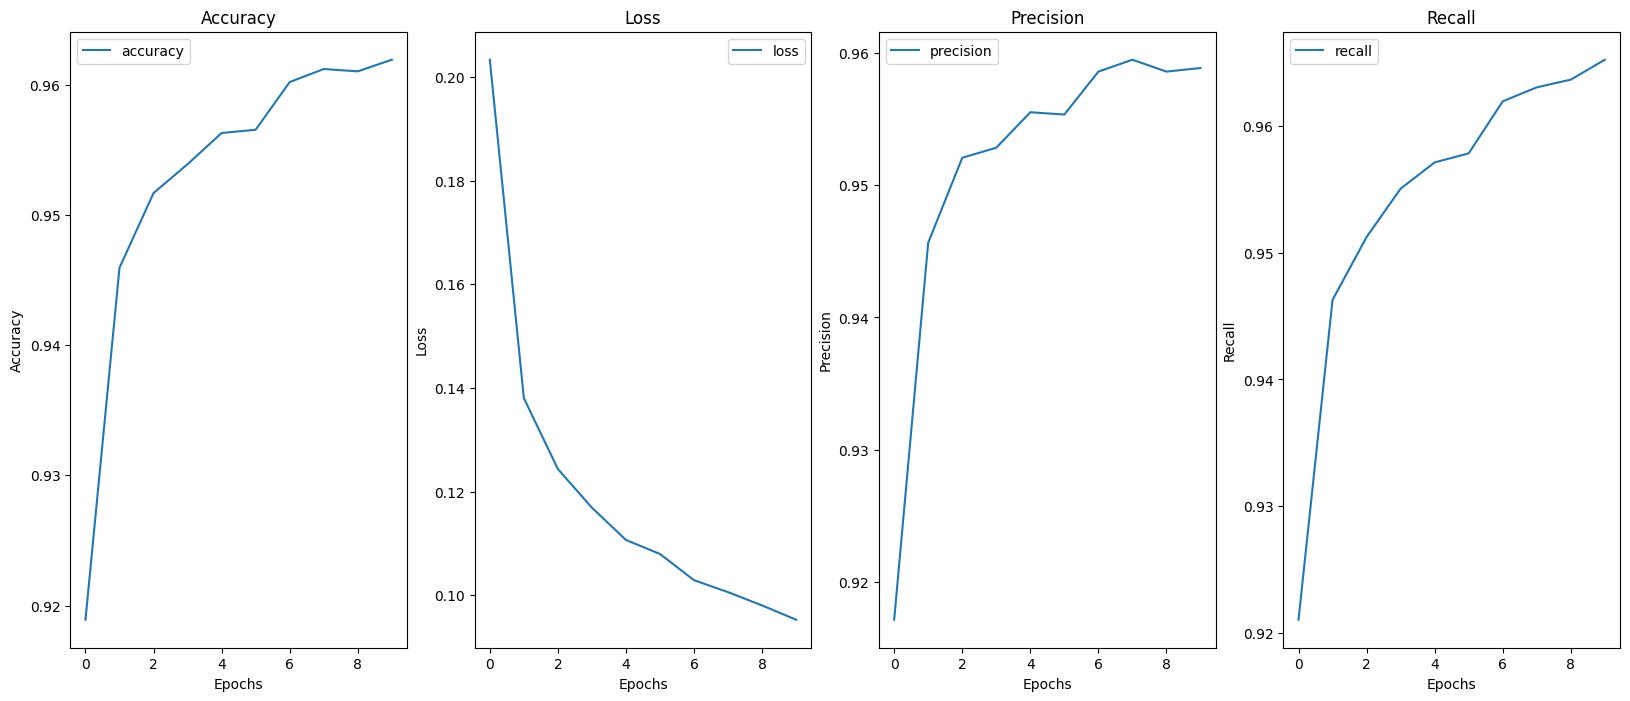

In [ ]:
acc = densenet_model_history.history['accuracy']
loss = densenet_model_history.history['loss']
prec = densenet_model_history.history['precision']
rec = densenet_model_history.history['recall']

plt.figure(figsize=(20, 8))

plt.subplot(1, 4, 1)
plt.plot(acc, label='accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 4, 2)
plt.plot(loss, label='loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 4, 3)
plt.plot(prec, label='precision')
plt.title('Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

plt.subplot(1, 4, 4)
plt.plot(rec, label='recall')
plt.title('Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()

In [ ]:
print("Manually saving the final model state...")
densenet_model.save('DenseNet121-AIvsHumanGenImages-Final.keras')
print("Model saved.")

Manually saving the final model state...
Model saved.


# Model Comparison

Berhasil memuat log untuk ResNet50V2
Berhasil memuat log untuk MobileNetV2
Berhasil memuat log untuk DenseNet121

Comparison plot has been save as 'model_comparison_plots.png'


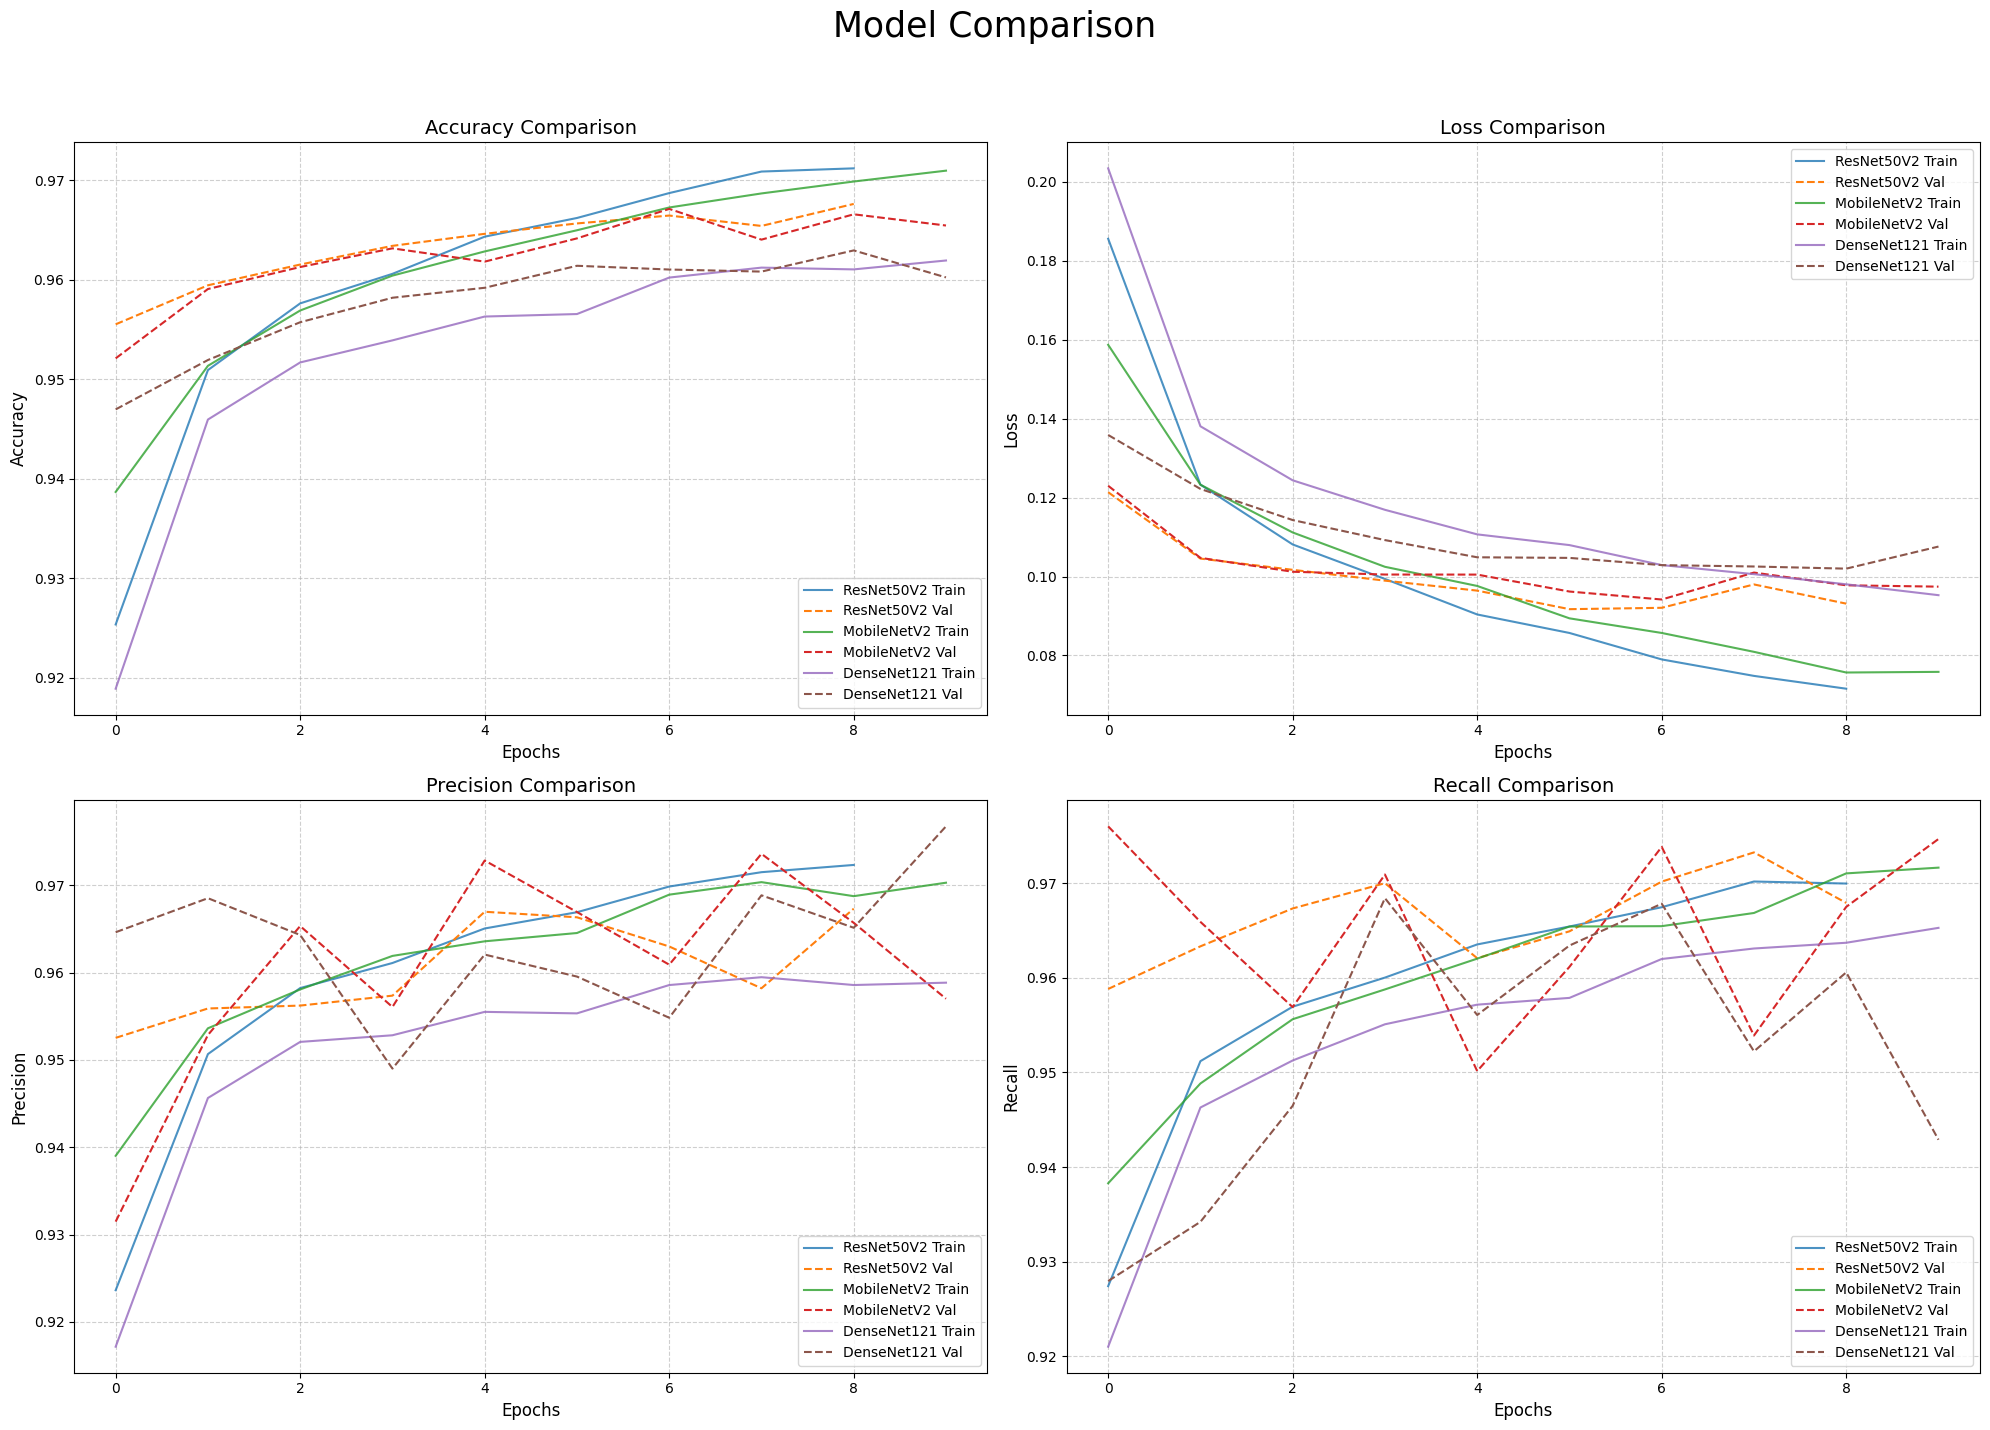

In [11]:
resnet_log_path = './logs/ResNet50V2-AIvsHumanGenImages-Logs.csv'
mobilenet_log_path = './logs/MobileNetV2-AIvsHumanGenImages-Logs.csv'
# efficientnet_log_path = './logs/EfficientNetB2-AIvsHumanGenImages-Logs.csv'
densenet_log_path = './logs/DenseNet121-AIvsHumanGenImages-Logs.csv'

history_files = {
    "ResNet50V2": resnet_log_path,
    "MobileNetV2": mobilenet_log_path,
    # "EfficientNetB2": efficientnet_log_path,
    "DenseNet121": densenet_log_path
}

histories = {}
for model_name, path in history_files.items():
    if os.path.exists(path):
        histories[model_name] = pd.read_csv(path)
        print(f"Berhasil memuat log untuk {model_name}")
    else:
        print(f"Peringatan: File log tidak ditemukan di '{path}'. Model '{model_name}' akan dilewati.")

if not histories:
    print("Tidak ada file log history yang dapat dimuat. Grafik tidak dapat dibuat.")
else:
    fig, axs = plt.subplots(2, 2, figsize=(20, 15))
    fig.suptitle('Model Comparison', fontsize=25)

    metrics = {
        'Accuracy': ('accuracy', 'val_accuracy'),
        'Loss': ('loss', 'val_loss'),
        'Precision': ('precision', 'val_precision'),
        'Recall': ('recall', 'val_recall')
    }

    plot_coords = [(0, 0), (0, 1), (1, 0), (1, 1)]

    for (metric_name, (train_metric, val_metric)), ax_coords in zip(metrics.items(), plot_coords):
        ax = axs[ax_coords]

        for model_name, history_df in histories.items():
            if train_metric in history_df and val_metric in history_df:
                ax.plot(history_df[train_metric], label=f'{model_name} Train', alpha=0.8)
                ax.plot(history_df[val_metric], label=f'{model_name} Val', linestyle='--')

        ax.set_title(f'{metric_name} Comparison', fontsize=14)
        ax.set_xlabel('Epochs', fontsize=12)
        ax.set_ylabel(metric_name, fontsize=12)
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig('./plots/model_comparison_plots.png')
    print("\nComparison plot has been save as 'model_comparison_plots.png'")

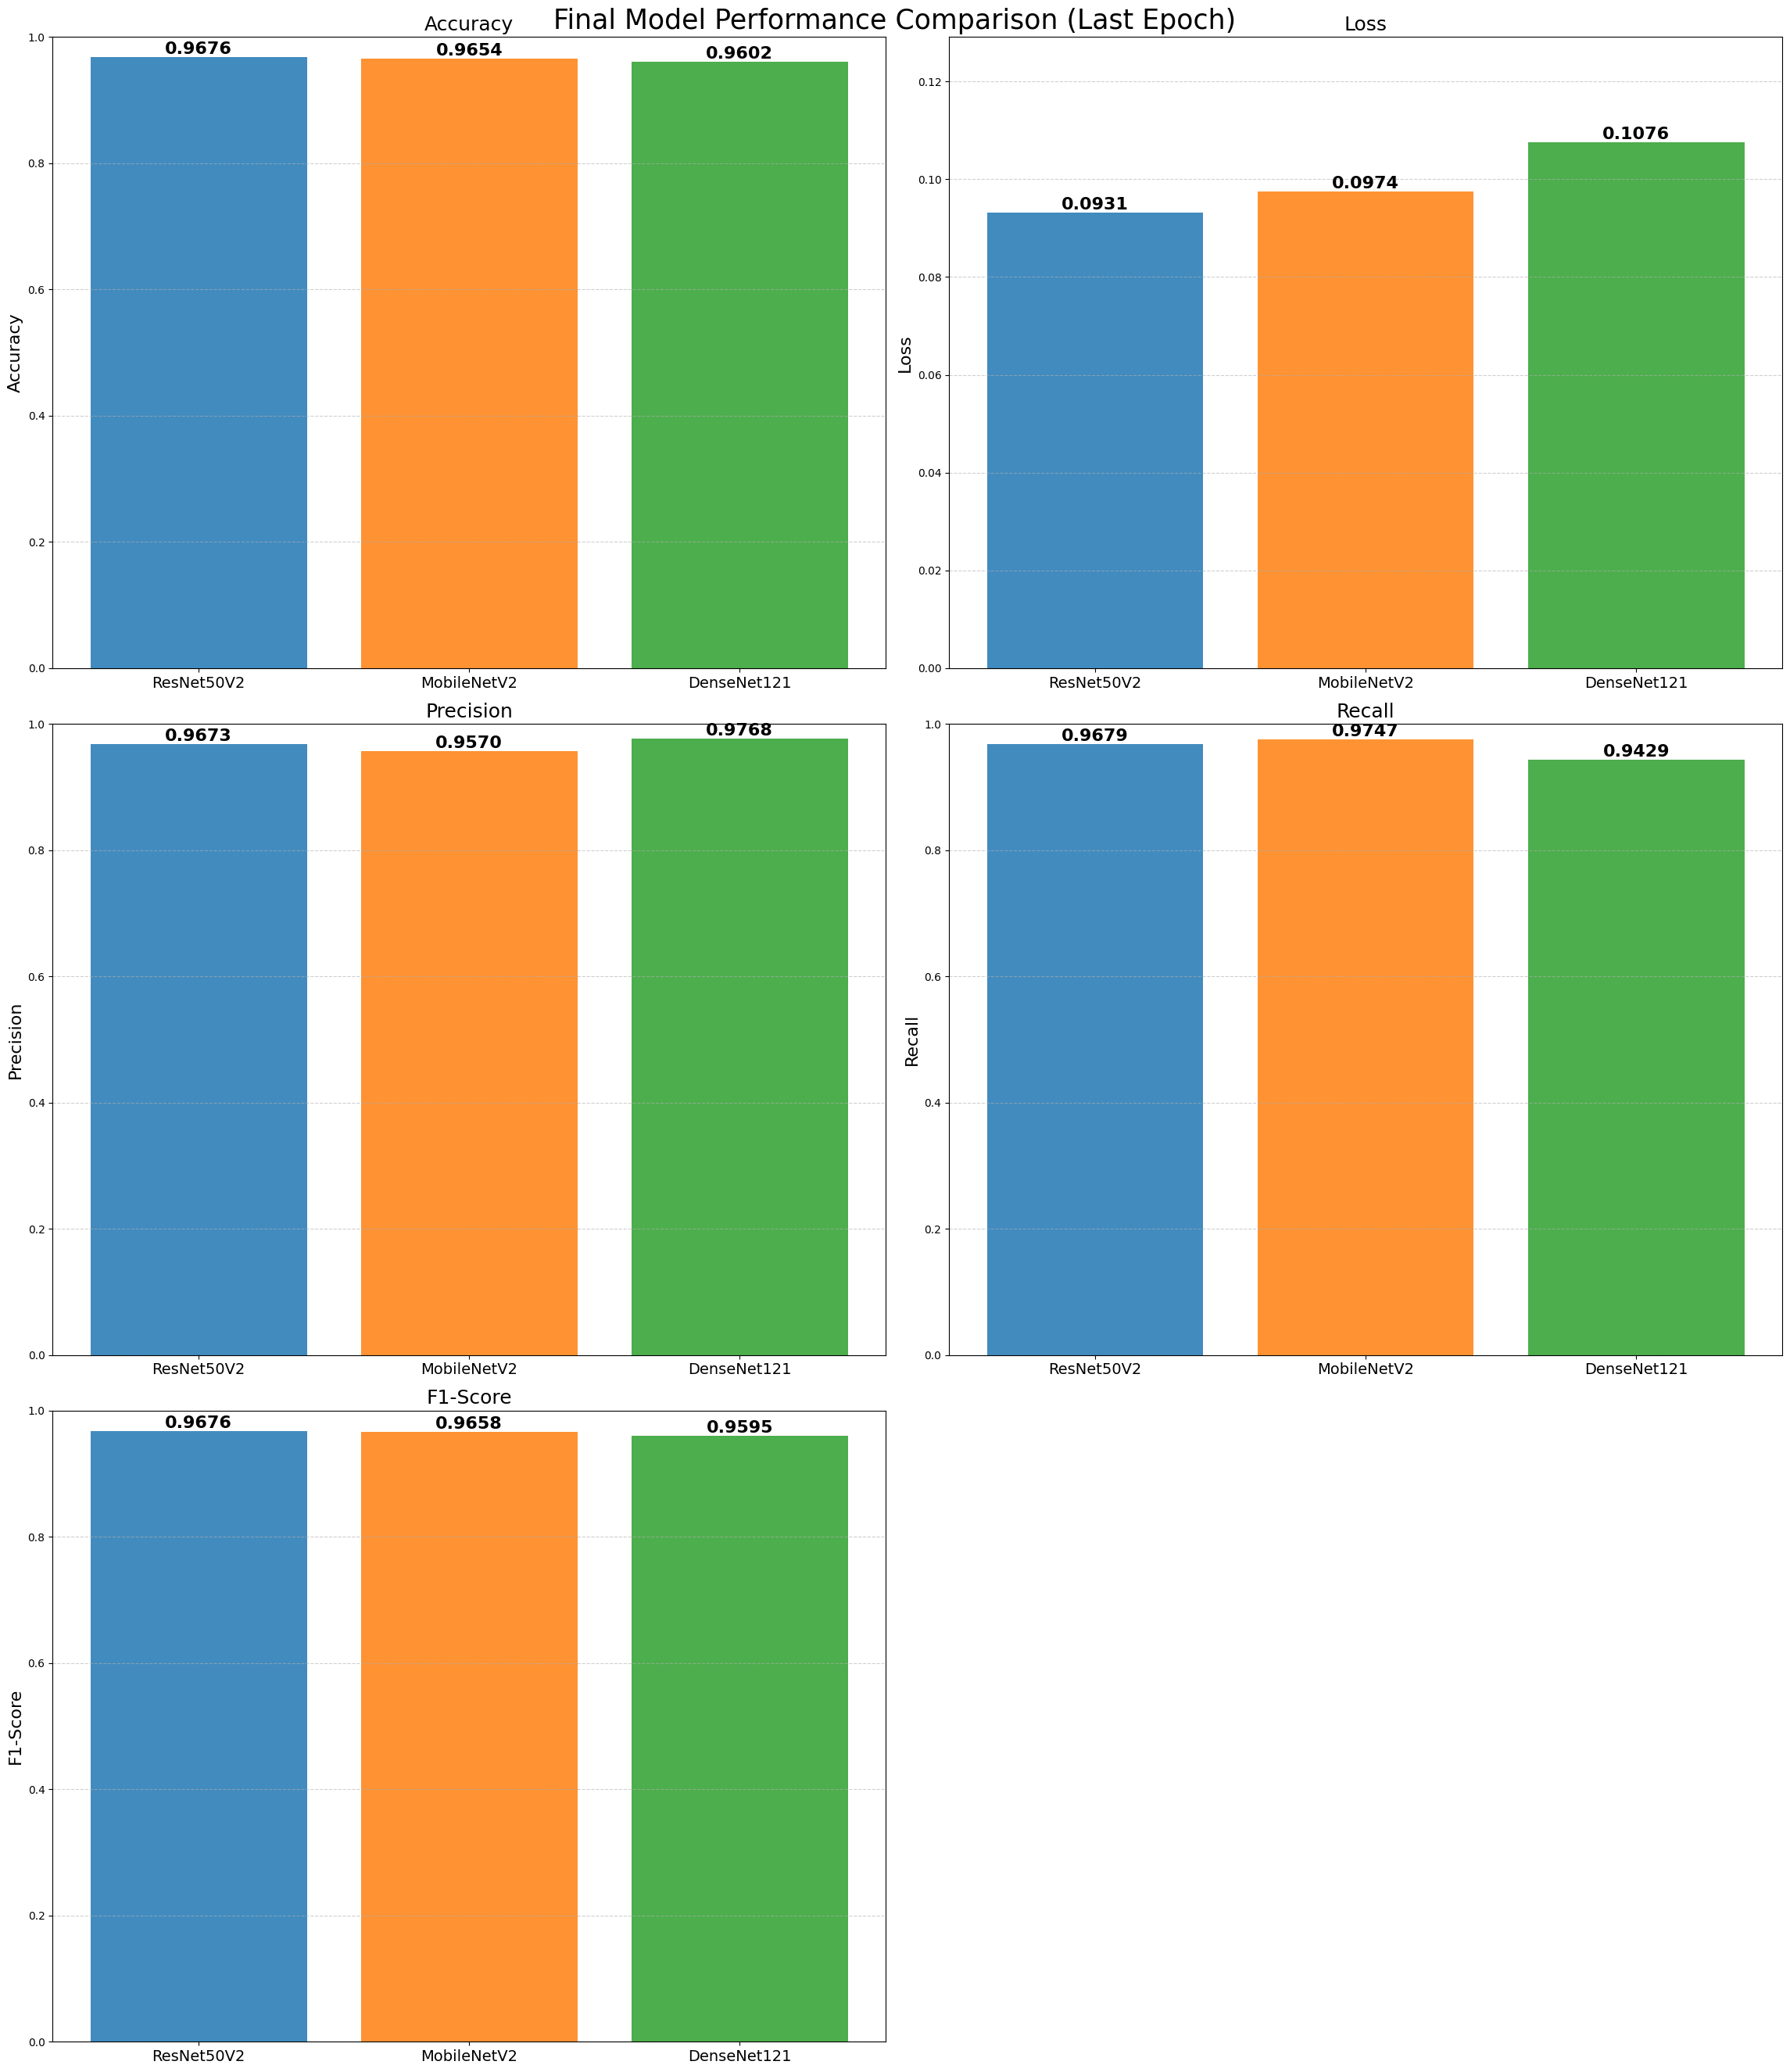

In [10]:
final_scores = {}

for model_name, history_df in histories.items():
    precision = history_df['val_precision'].iloc[-1]
    recall = history_df['val_recall'].iloc[-1]
    f1 = 2 * (precision * recall) / (precision + recall + 1e-8)

    final_scores[model_name] = {
        "Accuracy": history_df['val_accuracy'].iloc[-1],
        "Loss": history_df['val_loss'].iloc[-1],
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1
    }

metrics = ["Accuracy", "Loss", "Precision", "Recall", "F1-Score"]

colors = plt.cm.tab10.colors
model_names = list(final_scores.keys())
model_colors = {model: colors[i % len(colors)] for i, model in enumerate(model_names)}

fig, axs = plt.subplots(3, 2, figsize=(23, 27))
fig.suptitle('Final Model Performance Comparison (Last Epoch)', fontsize=25)

axs = axs.flatten()
plot_coords = range(len(metrics))

for metric, idx in zip(metrics, plot_coords):
    ax = axs[idx]
    values = [final_scores[m][metric] for m in final_scores]
    bars = ax.bar(model_names, values, color=[model_colors[m] for m in model_names], alpha=0.85)

    for bar, val in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                f'{val:.4f}', ha='center', va='bottom', fontsize=16, fontweight='bold')

    ax.set_title(metric, fontsize=18)
    ax.set_ylabel(metric, fontsize=16)
    ax.tick_params(axis='x', labelsize=14, labelrotation=0)
    ax.set_ylim(0, 1 if metric not in ["Loss"] else max(values) * 1.2)
    ax.grid(axis='y', linestyle='--', alpha=0.6)

for j in range(len(metrics), len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.savefig('./plots/model_comparison_barplots.png')
plt.show()